# Exploring images dataset

In [6]:
import pandas as pd
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numbers
from PIL import Image
import time
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import sklearn


# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.utils as vutils

# PL
import lightning.pytorch as pl


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()


5379


<Axes: >

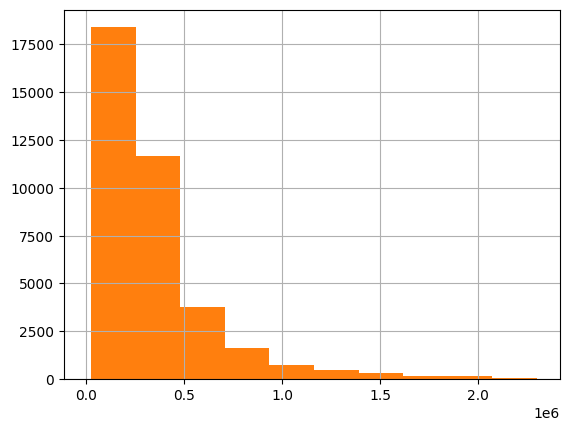

In [8]:
X_train = pd.read_csv("data/X_train_J01Z4CN.csv")
X_test = pd.read_csv("data/X_test_BEhvxAN.csv")
X_train["nb_photos"].hist()
X_train["nb_photos"].describe()
y_train_raw = pd.read_csv("data/y_train_OXxrJt1.csv")
print(len(y_train_raw["price"].unique()))
y_train_raw["price"].hist()

In [2]:
#utils
def display_images_in_folder(id_annonce,dataset="train", num_columns=3):
    # Get a list of all the image files in the folder
    folder_path =f"data/reduced_images/{dataset}/{id_annonce}"
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")] # Replace ".jpg" with the file extension of your image format
    
    # Calculate the number of rows needed based on the number of columns
    num_rows = (len(image_files) + num_columns - 1) // num_columns
    
    # Create a new blank image to use as the background for the grid
    grid_image = Image.new("RGB", (num_columns * 256, num_rows * 256))
    
    # Loop through each image file and paste it into the grid
    for i, image_file in enumerate(image_files):
        # Open the image file using Pillow
        image = Image.open(f"{folder_path}/{image_file}")
        display(image)

def display_image_by_id(folder_path="reduced_images/train",id_annonce="id_annonce", image_id=""):
    # Construct the file path to the image using the folder path and ID
    image_path = f"{folder_path}/{image_id}.jpg" # Replace ".jpg" with the file extension of your image format
    
    # Open the image file using Pillow
    image = Image.open(image_path)
    
    # Display the image
    image.show()

In [9]:
# params 
seed  = 66
debug = False

batch_size = {
    'gpu': 4, # 10 without AMP
    'cpu': 4,
}
BATCH_SIZE = 1
arch = 'efficientnet-b0'

resolution = 456  # orignal res for B5
input_res  = 512

lr = 8e-6   
weight_decay = 2e-5
pos_weight   = 3.2
label_smoothing = 0.03

MAX_EPOCHS = 10

In [10]:
# Seeds
warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed*6 + fold_number)

torch.__version__

NameError: name 'fold_number' is not defined

In [6]:
# Set up
num_workers = 4  # os.cpu_count()
gpus = 1 if torch.cuda.is_available() else None

if isinstance(batch_size, dict):
    if gpus:
        batch_size = batch_size['gpu']
        # support for free Colab GPU's
        if 'K80' in torch.cuda.get_device_name():
            batch_size = batch_size//3
        elif 'T4' in torch.cuda.get_device_name():
            batch_size = int(batch_size * 0.66)
    else:
        batch_size = batch_size['cpu']

lr *= batch_size

dict(
    num_workers=num_workers,
    gpus=gpus,
    batch_size=batch_size,
    lr=lr,
)

{'num_workers': 4, 'gpus': 1, 'batch_size': 2, 'lr': 1.6e-05}

In [11]:
# Transforms
data_transforms = {
    'train': transforms.Compose([
        #transforms.Pad(padding, fill=0, padding_mode='constant'),
        #transforms.Resize((342,460)), # 224   342 460
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize((342,460)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
class RealDataset(Dataset):
    """Real dataset."""

    def __init__(self,root_dir, csv_file, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.target = self.df.price
        self.__quantize__() # Quantize targets for classification
        
        self.root_dir = root_dir
        self.transform = transform

    def __quantize__(self):
        self.target_quantized = self.target//100
        self.target_quantized = self.target_quantized.astype("int32")
        self.target_classes, self.target_price = pd.factorize(self.target_quantized)
        self.target_price = self.target_price.to_numpy()
        self.target_log = np.log(self.target)

    def resize_images(self, images):
        # Calculate the average width and height
        total_width = 0
        total_height = 0
        num_images = len(images)
        for img in images:
            total_width += img.width
            total_height += img.height
        avg_width = total_width // num_images
        avg_height = total_height // num_images
        # Resize all the images to the average size
        resized_images = []
        for img in images:
            resized_img = img.resize((avg_width, avg_height))
            resized_images.append(resized_img)

        return resized_images
    
    
    def __stack__(self, id):
        full_path = os.path.join(self.root_dir,f"ann_{id}")
        images_paths = glob.glob(f"{full_path}/*.jpg" )
        images = [Image.open(i) for i in images_paths]

        new_images = self.resize_images(images)
        
        # Get dimensions of all images
        heights = [img.size[1] for img in new_images]
        widths = [img.size[0] for img in new_images]

        # Find the maximum height and width among all images
        n_images = len(images)
        n_rows = n_images//2 + (n_images%2>0)
        max_height = max(heights)
        current_width=0
        for i in range(n_rows):
            width, height = new_images[i].size
            current_width += width
        max_width = current_width

        # Create a new image with the maximum height and total width
        stacked_image = Image.new('RGB', (max_width, max_height*2))

        # Iterate over each image and copy it to the stacked image on a new column
        current_width = 0
        current_width=0
        for i in range(n_rows):
            width, height = new_images[i].size
            stacked_image.paste(new_images[i], (current_width, 0))
            current_width += width
            
        current_width = 0
        for j in range(n_rows, len(images)):
            width, height = new_images[i].size
            stacked_image.paste(new_images[j], (current_width, max_height))
            current_width += width

        return stacked_image
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        id_annonce = int(self.df.iloc[idx]["id_annonce"])

        image = self.__stack__(id_annonce)
        price = self.target_log[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, price

In [13]:
full_dataset = RealDataset("data/reduced_images/train", "data/y_train_OXxrJt1.csv", None) 

In [14]:
full_dataset.target_log

0        12.779873
1        12.154779
2        10.571317
3        12.608199
4        13.077366
           ...    
37363    12.154779
37364    12.896717
37365    12.700769
37366    13.045482
37367    11.155250
Name: price, Length: 37368, dtype: float64

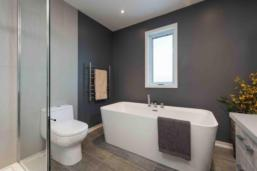

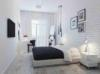

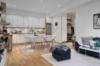

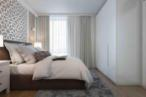

In [11]:
display_images_in_folder('ann_35996577')

In [15]:
full_dataset = RealDataset("data/reduced_images/train", "data/y_train_OXxrJt1.csv", data_transforms["train"]) 

In [16]:
len(full_dataset.target_price)

4176

In [17]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
SEED = 42

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(full_dataset)),
    full_dataset.target,
    test_size=TEST_SIZE,
    random_state=SEED
)

ds_train = Subset(full_dataset, train_indices)
ds_val = Subset(full_dataset, test_indices)

# create batches
train_batches = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(ds_val, batch_size=BATCH_SIZE)

In [18]:
batch, targets = next(iter(train_batches))

In [19]:
batch.shape, targets

(torch.Size([1, 3, 312, 216]), tensor([12.1548], dtype=torch.float64))

In [20]:
len(train_batches), len(test_batches)

(29894, 7474)

In [24]:
fig = plt.figure()

for i in range(len(full_dataset)):
    
        image, price = full_dataset[i]
        #plt.imshow(image.cpu())
        #plt.show()


        if i == 10:
            break


<Figure size 640x480 with 0 Axes>

In [25]:
len(ds_train), len(ds_val)

(29894, 7474)

In [26]:
len(full_dataset.target_price)

4176

In [27]:
full_dataset.target_price

array([ 3550,  1900,   390, ...,  7010, 11075,  2013])

In [32]:
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import roc_auc_score
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import R2Score

logger = TensorBoardLogger("tb_logs", name="my_model")

def my_loss(output, target):
    loss = torch.sqrt(torch.mean((output - target)**2))
    return loss

class Model(pl.LightningModule):

    def __init__(self, *args, **kwargs):
        super().__init__()
        self.num_target_classes = len(full_dataset.target_price)
        self.net = EfficientNet.from_pretrained(arch, advprop=True,num_classes=self.num_target_classes)
        # Create loss function

        self.softmax = nn.Softmax()
        self.linear = torch.nn.Linear(len(full_dataset.target_price), 1, bias=True)
        self.relu = nn.ReLU()
        self.loss_fn = my_loss
        self.acc = R2Score()
        self.val_output_list = []
        self.train_output_list = []

    def forward(self, x):
        x2 = self.net(x)
        x3 = self.linear(x2)
        output = self.relu(x3).squeeze(1)
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            max_lr=lr,
            epochs=MAX_EPOCHS,
            optimizer=optimizer,
            steps_per_epoch=int(len(ds_train) / BATCH_SIZE),
            pct_start=0.1,
            div_factor=10,
            final_div_factor=100,
            base_momentum=0.90,
            max_momentum=0.95,
        )
        return {'optimizer':optimizer, 'scheduler':scheduler}

    def step(self, batch):
        # return batch loss
        x, y  = batch
        y_hat = self.forward(x)
        # print(y, y.size())
        # print(y_hat, y_hat.size())
        # prices = torch.tensor(full_dataset.target_price).to('cuda')
        # print(prices.size(), prices)
        # y_hat = torch.sum(prices*y_hat)
        # y_hat = y_hat.unsqueeze(0)
        # print("Predicted y : ", y_hat, " vs ", y.cpu().numpy())
        # print(y.size(), y_hat.size())
        return y, y_hat


    def training_step(self, batch, batch_nb):
        # hardware agnostic training
        y, y_hat = self.step(batch)

        loss = self.loss_fn(y_hat, y)

        self.log("Train_loss", loss, prog_bar=True)
        self.train_output_list.append((y,y_hat)) 
        return loss 

    def on_train_epoch_end(self):
        preds = []
        targets = []

        for output in self.train_output_list:
            preds.append(output[1])
            targets.append(output[0])
        
        targets = torch.stack(targets)
        preds = torch.stack(preds) 

        acc = self.acc(preds, targets)
        self.log("R2_Train", acc)
        self.train_output_list.clear()
        return {
            "R2": acc,
        }
    
    def validation_step(self, batch, batch_nb):
        y, y_hat = self.step(batch)
        # acc = self.acc(y_hat, y )
        loss = self.loss_fn(y_hat, y)
        results = {
                    'val_loss': loss, 
                    'y': y.detach(), 
                    'y_hat': y_hat.detach()
                    }
        self.log("Val_loss", loss, prog_bar=True)

        self.val_output_list.append(results)
        return results

    def on_validation_epoch_end(self):
        preds = []
        targets = []

        for output in self.val_output_list:
            preds.append(output['y_hat'])
            targets.append(output['y'])
        
        targets = torch.stack(targets)
        preds = torch.stack(preds) 

        acc = self.acc(preds, targets)
        self.log("R2_val", acc)
        self.val_output_list.clear()
        return {
            "R2": acc,
        }

    def train_dataloader(self):
        return DataLoader(ds_train, batch_size=BATCH_SIZE,shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


model = Model()

Loaded pretrained weights for efficientnet-b0


In [33]:
trainer = pl.Trainer(fast_dev_run=5,
                     devices=3,
                     accelerator="gpu")
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 5 batch(es). Logging and checkpointing is suppressed.
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
----------------------------------------------------------------------------------------------------



ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 69, in _wrap
    fn(i, *args)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/lightning/pytorch/strategies/launchers/multiprocessing.py", line 147, in _wrapping_function
    results = function(*args, **kwargs)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 559, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 894, in _run
    self.__setup_profiler()
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 1024, in __setup_profiler
    self.profiler.setup(stage=self.state.fn, local_rank=local_rank, log_dir=self.log_dir)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 1145, in log_dir
    dirpath = self.strategy.broadcast(dirpath)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/lightning/pytorch/strategies/ddp.py", line 294, in broadcast
    torch.distributed.broadcast_object_list(obj, src, group=_group.WORLD)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py", line 1436, in wrapper
    return func(*args, **kwargs)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py", line 2240, in broadcast_object_list
    broadcast(object_sizes_tensor, src=src, group=group)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py", line 1436, in wrapper
    return func(*args, **kwargs)
  File "/home/alaassairi/anaconda3/envs/classif/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py", line 1551, in broadcast
    work = default_pg.broadcast([tensor], opts)
torch.distributed.DistBackendError: NCCL error in: ../torch/csrc/distributed/c10d/NCCLUtils.hpp:121, unhandled cuda error, NCCL version 2.14.3
ncclUnhandledCudaError: Call to CUDA function failed.
Last error:
Cuda failure 'out of memory'


In [ ]:
# Plot some training images
batch, targets = next(iter(model.train_dataloader()))

tensor([12.1548], dtype=torch.float64)

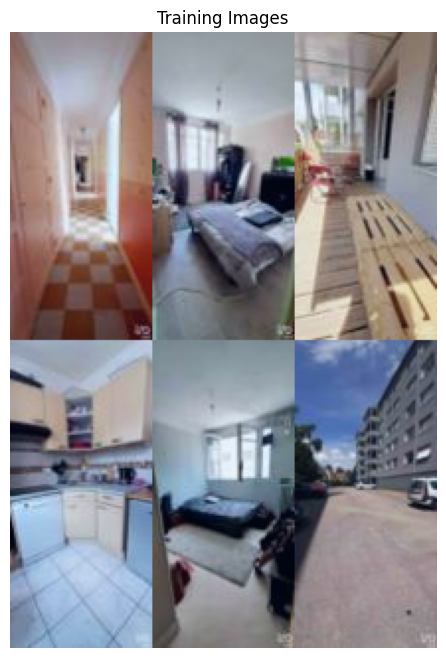

In [34]:
plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images")
_ = plt.imshow(vutils.make_grid(
    batch[:16], nrow=8, padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0)))

targets[:16].reshape([2, 8]) if len(targets) >= 16 else targets

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = pl.Trainer(
    logger=logger,
    # limit_train_batches=1, 
    # limit_val_batches=1,
    accelerator="gpu",
    devices=[0, 1, 2]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
%tensorboard --logdir=runs

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
trainer.fit(model)

Missing logger folder: tb_logs/my_model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7,8,9]

  | Name    | Type         | Params
-----------------------------------------
0 | net     | EfficientNet | 9.4 M 
1 | softmax | Softmax      | 0     
2 | linear  | Linear       | 4.2 K 
3 | relu    | ReLU         | 0     
4 | acc     | R2Score      | 0     
-----------------------------------------
9.4 M     Trainable params
0         Non-trainable params
9.4 M     Total params
37.445    Total estimated model params size (MB)
2023-05-01 11:00:28.162379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 11:00:28.902203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 11.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 34.1 MB/s eta 0:00:00


In [ ]:
import timm
model = timm.create_model('efficientnet_b3a',pretrained=True,num_classes=0, global_pool='')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /home/alaassairi/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [ ]:
import torch
x = torch.rand(1,3, 400, 300)
y= model(x)
print(y.shape)

torch.Size([1, 1536, 13, 10])


In [ ]:
x = torch.rand(1,3, 800, 200)
y= model(x)
print(y.shape)

torch.Size([1, 1536, 25, 7])
